# Demontrating Factory Production Improvement Techniques with SimPy

### Intro and Motivation

This project seeks to provide a demonstration of how two manufacturing process improvement techniques commonly used in lean manufacturing can result in dramatic benefits to cost and lead time. The two techniques that will be explored are **resource pooling** and **lot sizing**. 

My personal goal for this project is to improve my simulation skills and put theory to practice in a realistic and challenging way.

I will be using a discrete-event-simulation of a generic PCB manufacturing plant to compare and evaluate different improvement techniques. The simulation runs in a [SimPy](https://simpy.readthedocs.io/en/latest/) environment and uses monte-carlo methods to introduce unpredictable variability to the system to mimic real-life processes. 

## Scenario 

Olympic LLC. is a specialty Printed Control Board (PCB) manufacturer based in the United States. It provies a wide range of PCB products to regional wholesale consumers who then install these boards as controllers for their lines of heathcare devices. Given the sensitive nature the work these devices are doing, testing of these PCB's are incredibly important to prevent failure or faulty readings. As a result, Olympic invests heavily into manual testing and QC of their products before they reach their customers. 

####       Manufacturing Issues
Prior to the investmnt in extensive QC testing, Olympic was able to manufacture and ship an order of product directly to customers in well under 5 days. Unfortunately, customer complaints of faulty units and potential lawsuits forced management to require standardized testing at every stage of the production process. Under no circumstances could a faulty unit be delivered to a customer. Testing for each board is a tedious process and no automated machine exists that could perform faster or cheaper than a human tester, which is why Olympic has hired dozens of testers for their plant. 

Unfortunately, there is wide variability in the time it takes one tester to complete the task. This has resulted in large swings in order lead times and a whipsaw effect on production in which there are frequent periods of 100% utilization and other periods when utilization falls below 5%. Queueing theory would suggest that this system dynamic is expected given the high degree of dependent events and unpredictable variability.

Customers expect lead times to be below 5 days and, per the purchasing contract with the customer, for every hour the order is late to the customer warehouse, Olympic has to discount the final order invoice by $600 for every hour late. Lately, lead times have occasionally exceeded 7 or 8 days, resulting in significant lost revenues. Customers are unwilling to accept higher prices and will not agree to a new contract.

Management has reviewed the financials and has concluded that without major improvements in profitability, the SD-2-28 line will be discontinued. 

####       Production Process in Detail
Olympic's most popular PCB product, the SD-2-28, has three stages of production: 
1. Board Machining/Etching
2. Component Assembly
3. Finishing

Each stage has its own dedicated specialized machines, setup times, process times, random variation, and standardized testing requirements. If a unit fails a test (anywhere between 1.5 to 5 percent of the time), the unit will be sent back to the beginning of the stage and re-processed and re-tested before proceeding to the subsequent stage. The testing process is largely the same across production stages, but presently, every tester has a specified stage that he or she is assigned to and will not change throughout their shift.  

Orders are standardized at 50 units per order. Because the machines can only handle 10 units at a time, when an order is received, raw materials for 50 units are gathered and the order is broken down into lots of 10 units each, and each lot is sent down the production process separately. When all lots of an order are completed with the process, the order is packaged and immediately shipped to the customer warehouse.  

Every production step has its own work-in-process (WIP) queue, meaning that if there are not enough machines or testers available, a queue of units will build up until one becomes available. For the purposes of this project, assume that there is no limit to the number of units that can pile up behind a stage.  

The following gives a simplified illustration of the manufacturing process flow:

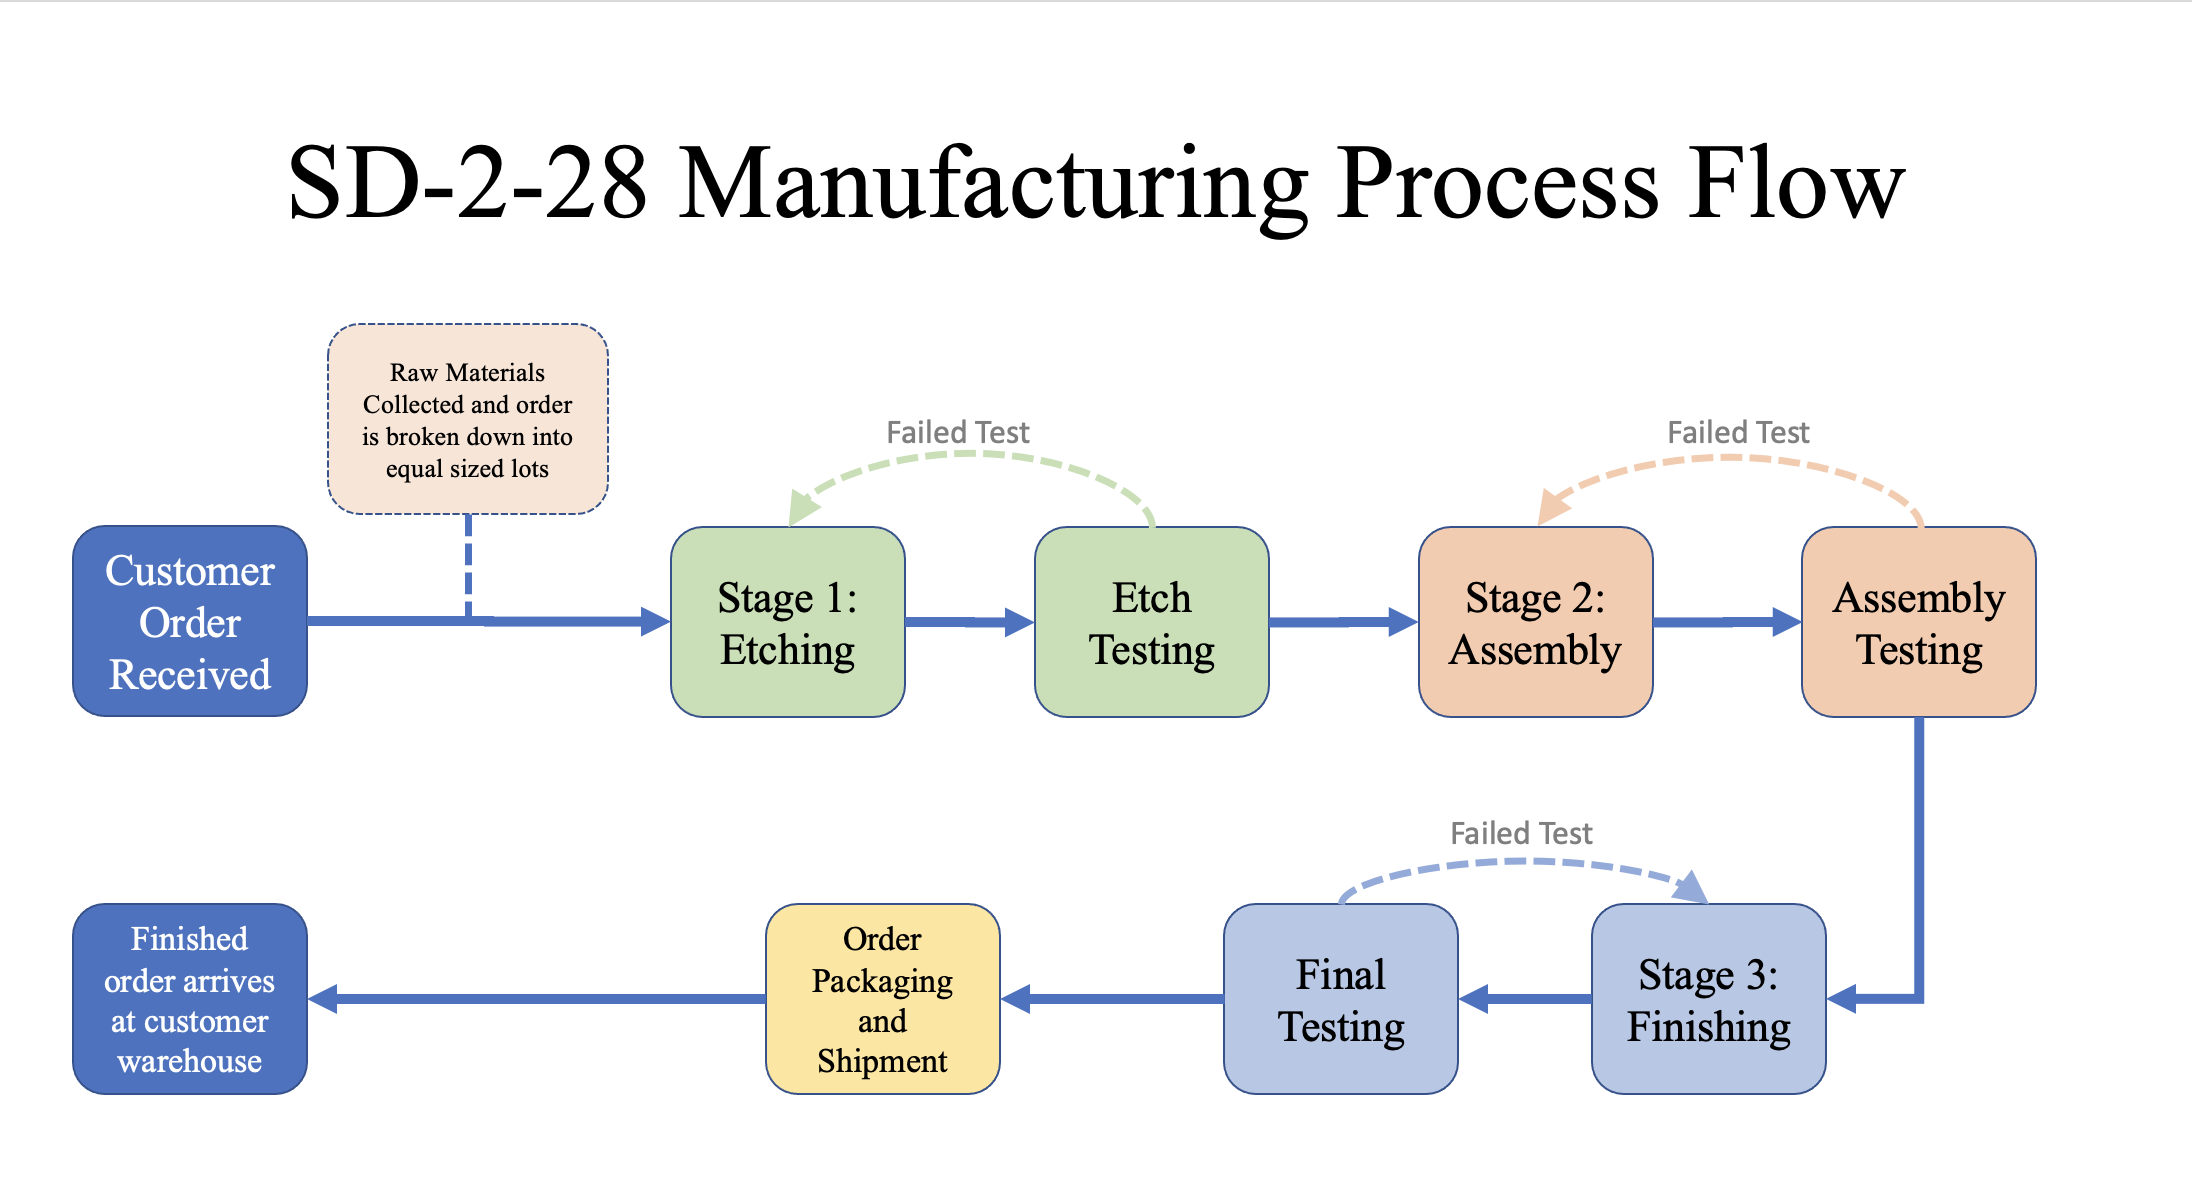



Additionally, here is a breakdown of the process times, number of machines, and number of testers at every stage:

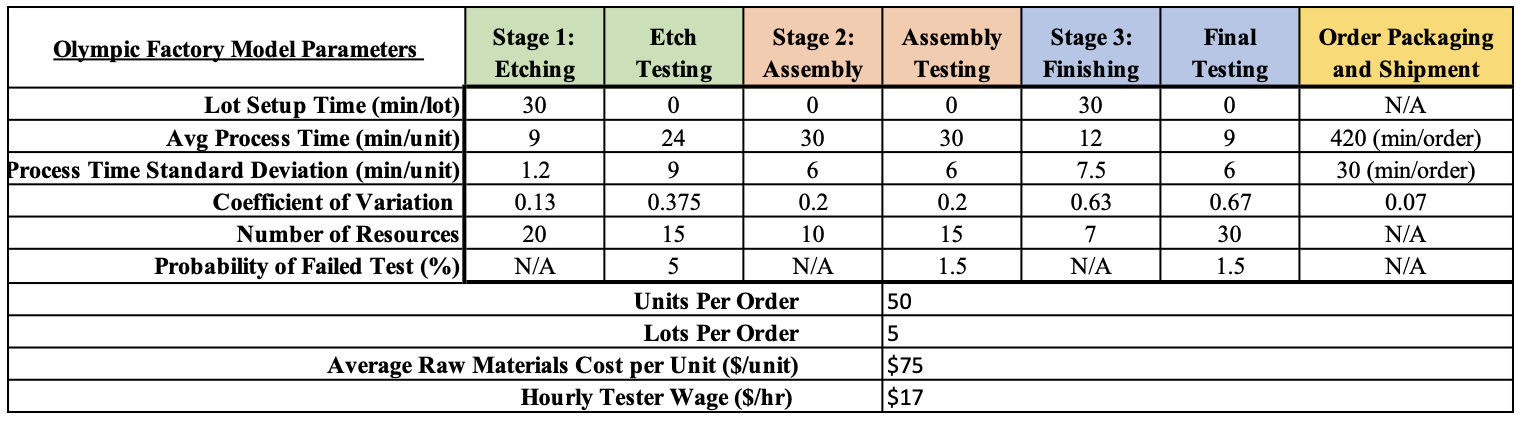



Lastly, here are the details on customer demand and the prices associated with customer contracts:

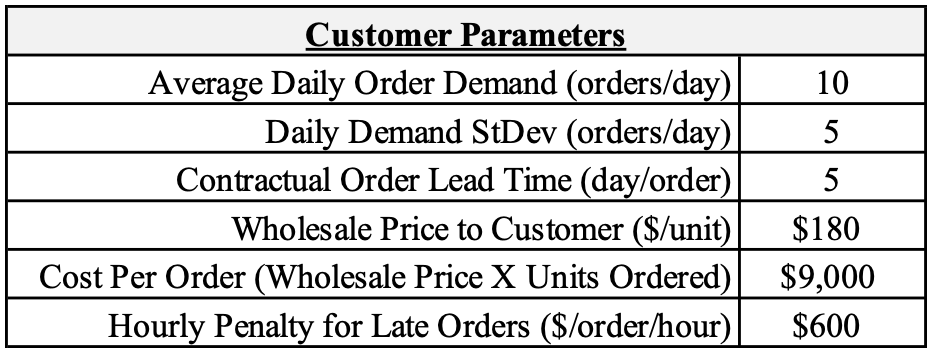


#### Problem Statement

Olympic management has refused requests to provide additional capital or debt to the production line. Any improvements to the profitability of the SD-2-28 must be made at no cost to Olympic. 

**As a plant manager, what changes can you make to your plant to return the product to sustainable profitability?**

## Simulation Model 

An important first step at solving the problem is to understand the problem quantitatively. Especially when unpredictable variability is inherent in a system, an effective way to analyze the situation is to create a discrete-event-simulation. The SimPy library is an excellent open source tool for just this purpose. It uses generator functions to replicate real-world time steps, so it can capture complex system behavior. The model will attempt to replicate the factory's performance over a period of **60 days**.

In [5]:
import simpy
import random
import pandas as pd
import matplotlib.pyplot as plt

random.seed(60)

In [6]:
class g:
    """Global class to establish scenario parameters"""
    
   ##Customer Demand
    d_arr = 10                #Average customer demand in orders per day (orders/day)
    d_std = 5                 #Standard deviation of customer demand (orders/day)
    d_intarrival = 24/d_arr   #Translates demand in orders per day to hours between orders
    d_int_std = 24/d_std      #Translates standard deviation of demand to std_dev of demand interarrival times
    
   ##Order Processing Parameters
    units_per_order= 50       #How many units are purchased in every order
    lots_per_order = 5        #How many lots is the order broken into
    units_per_lot = units_per_order/lots_per_order    #Converts units per order to units per lot
      
   ##Contract Financial Parameters
    cogs = 75                  #Average cost per unit (sum of cost of raw goods of one unit) ($)
    wholesale_price = 180      #The contractually agreed upon wholesale unit price that the customer is paying for finished units ($)
    quoted_lead = 60           #Contractually agreed upon lead time for one order (hrs)
    order_revenue = wholesale_price * units_per_order      #Revenue for one order ($)
    hourly_penalty = 600       #How much revenue you will forfeit for every hour late (in $)
 
   ##Factory Management Parameters
    tester_hr_wage = 17        #Hourly wage of one tester 
    
   ##Stages 1-4 Parameters 
    #Stage 1
    lot_time1 = 0.5            #How many hours it takes to set up one lot to go through an etching machine   
    mean_etching = 0.15        #How many hours on average it takes for the etching machine to etch one unit
    std_etching = 0.02         #Standard deviation of etching time per unit (in hrs/unit)
    machines1 = 20             #Number of etching machines the plant can use
    
    #Stage 1 Testing
    mean_test1 = 0.4           #How many hours on average it takes for one tester to ensure the unit etchings are within specification
    std_test1 = 0.15            #Standard deviation of test duration (hrs/unit)
    p_fail_test1 = 0.05        #Probability of a unit failing the etch testing
    testers1 = 15              #Number of etch testers 
    
    #Stage 2 Assembly 
    mean_assembly = 0.5        #How many hours on average it takes for one machine to do assembly stage (hrs/unit)
    std_assembly = 0.15        #Standard deviation of asembly stage time per unit (hrs/unit)
    machines2 = 10             #Number of assembly machines 
    
    #Stage 2 Testing
    mean_test2 = 0.5           #How many hours on average it takes one tester to conduct a functions check on one unit (hrs/unit)
    std_test2 = 0.1            #Standard deviation of average assembly test
    p_fail_test2 = 0.015       #Probaiblity of a unit failing the assembly test
    testers2 = 15              #Number of assembly testers
    
    #Stage 3 Finishing
    lot__time3 = 0.5           #How many hours on it takes to set up one lot on the finishing machines (hrs/lot)
    mean_finishing = 0.2       #How many hours on average it takes for one machine to conduct finishing on one unit (hrs/unit)
    std_finishing = 0.15       #Standard deviation of average finishing time (hrs/unit)
    machines3 = 7              #Number of finishing machines
    
    #Stage 3 Testing
    mean_test3 = 0.15          #How many hours on average it takes one tester to conduct final testing on a unit (hrs/unit)
    std_test3 = 0.1            #Standard deviation of average final testing (hrs/unit)
    p_fail_test3 = 0.015       #Probability of a unit failing the final functions testing
    testers3 = 30              #Number of final functions check testers
    
    #Stage 4 Packaging and Shipping
    mean_ship = 7              #How many hours on average it takes to package and ship a single order to the customer (hrs/order)
    std_ship = .5              #Standard deviation of average time for packaging and shipping of a single order (hrs/order)
    
    order_service_level = 0.95 #Metric used later to show order fill time at a specific service level 
    
    sim_duration = 60*24       #Simulation duration (hrs)
    

In [7]:
class Lot: 
    """Class that tracks the id attributes and time performance of every lot"""
    
    def __init__(self, unique_id, order_id, lot_id):
        self.unique_id = unique_id
        self.order_id = order_id
        self.id = lot_id
        self.start_time = 0
        self.end_time = 0

In [8]:
class Olympic_Model:
    """This class is the model itself, it will run until the simulation duration is complete. 
       No global variables are re-defined or changed when model is executed"""
       
    def __init__(self, run_number):
        self.env = simpy.Environment()
        self.run_number = run_number
        self.unique_id_counter = 1
        self.order_counter = 0
        self.lot_counter = 1
        self.cost_per_lot = g.units_per_lot*g.cogs
        self.failed_tests = 0

        
        self.etch_machine = simpy.Resource(self.env, capacity = g.machines1)
        self.assembly_machine = simpy.Resource(self.env, capacity = g.machines2)
        self.finishing_machine = simpy.Resource(self.env, capacity = g.machines3)
        
        self.etch_tester = simpy.Resource(self.env, capacity = g.testers1)
        self.assembly_tester = simpy.Resource(self.env, capacity = g.testers2)
        self.finishing_tester = simpy.Resource(self.env, capacity = g.testers3)
        self.testers = g.testers1 + g.testers2 + g.testers3
        self.hrly_test_expense = self.testers * g.tester_hr_wage
        
        #Create dataframe to store the information about every lot
        self.lots_df = pd.DataFrame()
        #Datafrme to store information about every completed order
        self.orders_df = pd.DataFrame()
        #Dataframe to store time series data about queue lengths
        self.q_df = pd.DataFrame()
        #Dataframe to store time series data of cash position
        self.cash_df = pd.DataFrame()
        
    def log_cash(self, time, revenue, cogs, wages, note):
        """Function that, when called, logs the change in cash position to the firm's books.
           For this model, only revenue generated from completed orders, 
           cost of goods sold, and wage expenses are logged as cash expenses."""
           
        cash_df_to_add = pd.DataFrame({"Time":[time],
                                           "Revenue":[revenue],
                                           "COGS_Expense":[cogs],
                                           "Wage_Expense":[wages],
                                           "Note":[note]})
        #cash_df_to_add.set_index("Time", inplace=True)
        self.cash_df = self.cash_df.append(cash_df_to_add)
            
    def profit_cumsum(self, data):
        """Function that adds columns to the cash dataframe that accumulates the change in cash position over time. 
           This will be used later to plot our P/L."""
           
        data["Cumulative_Revenue"] = data["Revenue"].cumsum()
        data["Cumulative_COGS"] = data["COGS_Expense"].cumsum()
        data["Cumulative_Wage_Expense"]=data["Wage_Expense"].cumsum()
        data["Cumulative_Profits"] = data.apply(lambda row: row["Cumulative_Revenue"] - row["Cumulative_COGS"] - row["Cumulative_Wage_Expense"], axis=1)
            
    def log_queue(self, etch, test1, assembly, test2, finishing, test3):
         """Function that will log to a dataframe the status of every machine at a specific point in time. 
           Datapoints include queue length and utilization rates."""
           
         while True:  
             q_df_to_add = pd.DataFrame({"Time":[self.env.now],
                                         "Total_Orders":[self.order_counter],
                                         "Etch_Q_Length":[len(etch.queue)],
                                         "Test1_Q_Length":[len(test1.queue)],
                                         "Assembly_Q_Length": [len(assembly.queue)],
                                         "Test2_Q_Length":[len(test2.queue)],
                                         "Finishing_Q_Length":[len(finishing.queue)],
                                         "Test3_Q_Length":[len(test3.queue)],
                                         "Etch_Utilization":[100*etch.count/g.machines1],
                                         "Test1_Utilization":[100*test1.count/g.testers1],
                                         "Assembly_Utilization":[100*assembly.count/g.machines2],
                                         "Test2_Utilization":[100*test2.count/g.testers2],
                                         "Finishing_Utilization":[100*finishing.count/g.machines3],
                                         "Test3_Utilization":[100*test3.count/g.testers3],
                                         "Failed_Tests":[self.failed_tests]})
             self.q_df = self.q_df.append(q_df_to_add)  
             yield self.env.timeout(g.sim_duration/100)
             
    def log_wage_expense(self):
        """Function that logs the total wage expense of all the testers every hour."""
        
        while True:
            self.log_cash(self.env.now,0,0,self.hrly_test_expense, "Wage_Expense")
            yield self.env.timeout(1)
            
    def store_lot_results(self,lot):
        """Function that stores the attribute data for every lot once it completes the production process"""
        
        df_to_add = pd.DataFrame({"Unique_ID":[lot.unique_id],
                                  "Order_ID":[lot.order_id],
                                  "Lot_ID":[lot.id], 
                                  "Start_Time":[lot.start_time],
                                  "End_Time":[lot.end_time]})
        df_to_add["Lot_Process_Time"] = df_to_add.apply(lambda row: row["End_Time"] - row["Start_Time"], axis=1)
        df_to_add.set_index("Unique_ID", inplace=True)
        self.lots_df = self.lots_df.append(df_to_add)
        
    def store_order_results(self, lot, lot_data):
        """Function that stores the attribute data of every completed order.
           This function is called only when all lots of an order have completed 
           the production process and the order was packaged and delivered to the customer"""
           
        df_to_add = pd.DataFrame({"Order_ID":[lot.order_id], 
                                  "Start_Time":[lot_data[lot_data.Order_ID == lot.order_id]["Start_Time"].min()],
                                  "End_Time":[lot_data[lot_data.Order_ID == lot.order_id]["End_Time"].max()]})
        df_to_add["Order_Process_Time"] = df_to_add.apply(lambda row: row["End_Time"] - row["Start_Time"] + random.gauss(g.mean_ship, g.std_ship), axis=1)
        df_to_add["Revenue_Generated"] = df_to_add.apply(lambda row: g.order_revenue if row["Order_Process_Time"] <= g.quoted_lead else max(0,g.order_revenue - ((row["Order_Process_Time"]-g.quoted_lead)*g.hourly_penalty)), axis=1)
        self.orders_df = self.orders_df.append(df_to_add)
    
    def etch_and_test(self,lot):
        """This is the function that models the etching and etch testing stages.
           If a lot fails a test, it will continue to call this function until it passes the etch test.
           This function is called recursively when a test failure occurs."""
           
        with self.etch_machine.request() as req:
            yield req 
            sampled_etch_duration = max(0,random.gauss(g.mean_etching, g.std_etching))
            yield self.env.timeout((sampled_etch_duration*g.units_per_lot)+g.lot_time1)
        with self.etch_tester.request() as req:
            yield req
            sampled_test1_duration = max(0,random.gauss(g.mean_test1, g.std_test1))
            yield self.env.timeout(sampled_test1_duration*g.units_per_lot)
            fail_test = random.uniform(0,1)
            if fail_test < g.p_fail_test1:
                self.failed_tests +=1
                yield self.env.process(self.etch_and_test(lot))
            else: pass 
        
    def assembly_and_test(self,lot):
        """This is the function that models the assembly and assembly testing stages.
           If a lot fails a test, it will continue to call this function until it passes the assembly test.
           This function is called recursively when a test failure occurs."""
           
        with self.etch_machine.request() as req:
            yield req 
            sampled_assembly_duration = max(0,random.gauss(g.mean_assembly, g.std_assembly))
            yield self.env.timeout(sampled_assembly_duration*g.units_per_lot)
            
        with self.assembly_tester.request() as req:
            yield req
            sampled_test2_duration = max(0,random.gauss(g.mean_test2, g.std_test2))
            yield self.env.timeout(sampled_test2_duration*g.units_per_lot)
            fail_test = random.uniform(0,1)
            
            if fail_test < g.p_fail_test2:
                self.failed_tests +=1
                yield self.env.process(self.assembly_and_test(lot))
            else: pass 
        
    def finishing_and_test(self,lot):
        """This is the function that models the finishing and final testing stages.
           If a lot fails a test, it will continue to call this function until it passes the final test.
           This function is called recursively when a test failure occurs."""
           
        with self.finishing_machine.request() as req:
            yield req 
            sampled_finishing_duration = max(0,random.gauss(g.mean_finishing, g.std_finishing))
            yield self.env.timeout(sampled_finishing_duration*g.units_per_lot)
            
        with self.finishing_tester.request() as req:
            yield req
            sampled_test3_duration = max(0,random.gauss(g.mean_test3, g.std_test3))
            yield self.env.timeout(sampled_test3_duration*g.units_per_lot*g.units_per_lot)
            fail_test = random.uniform(0,1)
            
            if fail_test < g.p_fail_test3:
                self.failed_tests +=1
                yield self.env.process(self.finishing_and_test(lot))
            else: pass 
   
    def generate_orders(self):
        """First generator function in the simpy environment. This function simulates order demand arriving to the factory.
           Demand is modeled as following a normal distribution, demand is inputted into the system as an interarrival time.
           Orders are then split into lots and lots are send through the production process."""
           
        while True:
            self.order_counter += 1
            self.lot_counter = 1
            #print(f"Order {self.order_counter} has been requested at {self.env.now:.5f}")
            for x in range(g.lots_per_order):
                l = Lot(self.unique_id_counter,self.order_counter, self.lot_counter)
                self.unique_id_counter += 1
                self.lot_counter += 1
                self.log_cash(self.env.now, 0, self.cost_per_lot,0,"COGS")
                self.env.process(self.lot_flow(l))
                #print(f"Lot {self.lot_counter} of order {self.order_counter} has been created")
            sampled_interarrival = max(0,random.gauss(g.d_intarrival, g.d_int_std))
            yield self.env.timeout(sampled_interarrival)
                
    def lot_flow(self,lot):
        """This function instantiates the flow of a single lot as it flows through the production process.
           Lot attributes, like start time and end time, are logged through this process. 
           Once a lot is completed in the system, a function within the lot_flow function checks whether or not all lots of the order are completed.
           If all lots of the order have completed the process flow, then the order is logged as being complete and revenue is recorded in the cash dataframe."""
        
        lot.start_time = self.env.now
        yield self.env.process(self.etch_and_test(lot))
        yield self.env.process(self.assembly_and_test(lot))
        yield self.env.process(self.finishing_and_test(lot))
        lot.end_time = self.env.now
        self.store_lot_results(lot)
        #print(f"Lot {lot.id} of order {lot.order_id} finished at {self.env.now}")
        if len(self.lots_df[self.lots_df.Order_ID == lot.order_id]) == g.lots_per_order:
            #print(f"*****Order {lot.order_id} finished at {self.env.now}")
            self.store_order_results(lot, self.lots_df)
            #print(self.orders_df)
            revenue = self.orders_df[self.orders_df.Order_ID == lot.order_id]["Revenue_Generated"][0]
            self.log_cash(self.env.now,revenue, 0,0,"Order Revenue")
            
    def run(self):
        """Function that when called, instantiates the model for a single run.
           When the model is complete, all dataframes are transferred from pandas df to .csv format"""
        self.env.process(self.generate_orders())
        self.env.process(self.log_queue(self.etch_machine, self.etch_tester, self.assembly_machine, self.assembly_tester, self.finishing_machine, self.finishing_tester))
        self.env.process(self.log_wage_expense())
        self.env.run(until = g.sim_duration)
        self.profit_cumsum(self.cash_df)
        self.cash_df.to_csv('cash_data.csv')
        self.q_df.to_csv('queue_data.csv')
        self.lots_df.to_csv('lot_data.csv')
        self.orders_df.to_csv('orders_data.csv')

Now that the model is created as its own class, we can instantiate the simpy environment with the following lines:

In [9]:
olympic_model = Olympic_Model(1)
olympic_model.run()

## Plotting Model Results

As a plant manager, we understand that the testers consume a significant amount of both time in the production process and a financial burden for the plant. We want to evaluate how each stage's testers are utilized over time and how long are their WIP queues due to being at max capacity. 

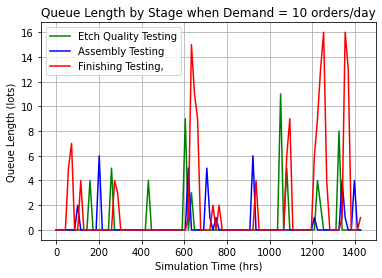

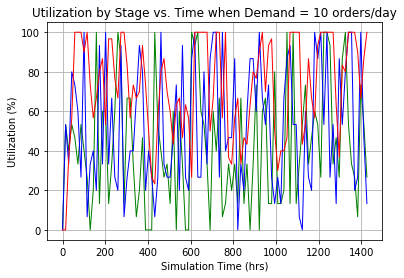

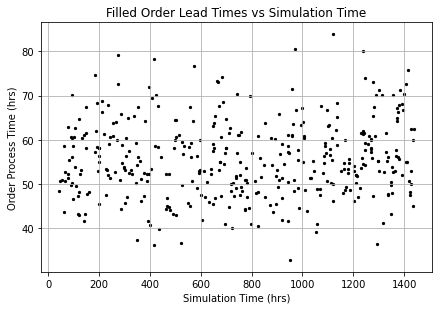

In [11]:
q_plot = pd.read_csv("queue_data.csv")
profit_plot = pd.read_csv("cash_data.csv")
order_plot = pd.read_csv("orders_data.csv")

fig, ax = plt.subplots()
#ax.plot(q_plot.Time, q_plot.Etch_Q_Length, label = "Etching Stage", color = 'g', linestyle = 'dashed')
ax.plot(q_plot.Time, q_plot.Test1_Q_Length, label = "Etch Quality Testing", color = 'g', )
#ax.plot(q_plot.Time, q_plot.Assembly_Q_Length, label = "Assembly Stage", color = 'b', linestyle = 'dashed')
ax.plot(q_plot.Time, q_plot.Test2_Q_Length, label = "Assembly Testing", color = 'b')
#ax.plot(q_plot.Time, q_plot.Finishing_Q_Length, label = "Finishing Stage,", color = 'r',linestyle = 'dashed')
ax.plot(q_plot.Time, q_plot.Test3_Q_Length, label = "Finishing Testing,", color = 'r')
plt.xlabel('Simulation Time (hrs)')
plt.ylabel('Queue Length (lots)')
plt.title(f'Queue Length by Stage when Demand = {g.d_arr} orders/day')
plt.legend()
plt.grid()
plt.show()   

fig, ax = plt.subplots()
#ax.plot(q_plot.Time, q_plot.Etch_Utilization, label = "Etching Stage", color = 'g', linestyle = 'dashed', linewidth = 1)
ax.plot(q_plot.Time, q_plot.Test1_Utilization, label = "Etch Quality Testing", color = 'g', linewidth = 1)
#ax.plot(q_plot.Time, q_plot.Assembly_Utilization, label = "Assembly Stage", color = 'b', linestyle = 'dashed', linewidth = 1)
ax.plot(q_plot.Time, q_plot.Test2_Utilization, label = "Assembly Testing", color = 'b', linewidth = 1)
#ax.plot(q_plot.Time, q_plot.Finishing_Utilization, label = "Finishing Stage,", color = 'r',linestyle = 'dashed', linewidth = 1)
ax.plot(q_plot.Time, q_plot.Test3_Utilization, label = "Finishing Testing,", color = 'r', linewidth = 1)
plt.xlabel('Simulation Time (hrs)')
plt.ylabel('Utilization (%)')
plt.title(f'Utilization by Stage vs. Time when Demand = {g.d_arr} orders/day')
#plt.legend()
plt.grid()
plt.show()  
    
fig, cx = plt.subplots()
cx.scatter(order_plot.End_Time, order_plot.Order_Process_Time, color = 'k', s=5)
plt.tight_layout()
plt.xlabel('Simulation Time (hrs)')
plt.ylabel('Order Process Time (hrs)')
plt.title('Filled Order Lead Times vs Simulation Time')
plt.grid()
plt.show()


As we can see, there are significant issues in the way the system currently behaves. We have multiple period in which all testing stages are flooded with lots, which drives up their WIP queues, resulting in higher order lead times. Additionally, we can see in the utilization plot that utilization varies widely, so there are many periods when testers are sitting idle and not working, and other periods when they are being overworked for hours without a break. 

These whipsaw dynamics make for an inefficient plant and a frustrating work environment. 

Now let's evaluate how these dynamics affect the bottom line. The following summary statistics and plot attempt to quantify just how poorly this plant is performing. 

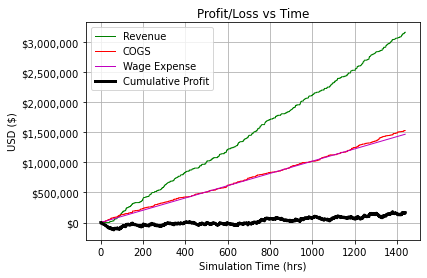


----------------------------------------------------------------
                  After 60.0 simulated days
----------------------------------------------------------------
       Total Possible Orders:        404
       Total On-Time Orders:         279
       Total Late Orders:            117
       On-Time Fill Rate:            69.06%
       Failed Test Count:            182
       Average Order Fill Time:      55.63 hours
       95th percentile Fill Time:    70.27 hours 
----------------------------------------------------------------
             Revenue:               $3,165,157.57
             COGS:                  -$1,530,000.00
             Wage Expenses:         -$1,468,800.00
                                    ---------------
             Gross Profit:          $166,357.57
             Gross Margin:          5.26%
----------------------------------------------------------------


In [13]:
fig, dx = plt.subplots()
dx.plot(profit_plot.Time, profit_plot.Cumulative_Revenue, label = "Revenue", color = 'g', linewidth = 1)
dx.plot(profit_plot.Time, profit_plot.Cumulative_COGS, label = "COGS", color = 'r', linewidth = 1)
dx.plot(profit_plot.Time, profit_plot.Cumulative_Wage_Expense, label = "Wage Expense", color = 'm', linewidth = 1)
dx.plot(profit_plot.Time, profit_plot.Cumulative_Profits, label = "Cumulative Profit", color = 'k', linewidth = 3)  
dx.yaxis.set_major_formatter('${x:,.0f}')
plt.legend()
plt.xlabel('Simulation Time (hrs)')
plt.ylabel('USD ($)')
plt.title('Profit/Loss vs Time')
plt.grid()
plt.show()

sim_days = g.sim_duration/24
total_orders = q_plot["Total_Orders"].max()
total_filled_orders = sum(order_plot.Revenue_Generated == g.wholesale_price*g.units_per_order)
total_late_orders = sum(order_plot.Revenue_Generated != g.wholesale_price*g.units_per_order)
on_time_fill_rate = 100*total_filled_orders/total_orders
order_process_mean = order_plot["Order_Process_Time"].mean()
order_process_service_level = order_plot["Order_Process_Time"].quantile(g.order_service_level)
revenue_generated = profit_plot["Cumulative_Revenue"].iat[-1]
cogs_generated = profit_plot["Cumulative_COGS"].iat[-1]
wage_generated = profit_plot["Cumulative_Wage_Expense"].iat[-1]
profit_generated = profit_plot["Cumulative_Profits"].iat[-1]
failed_tests= q_plot["Failed_Tests"].iat[-1]
gross_margin = 100*profit_generated/revenue_generated
print()
print("----------------------------------------------------------------")
print(f"                  After {sim_days:.1f} simulated days")    
print("----------------------------------------------------------------")
print(f"       Total Possible Orders:        {total_orders}")
print(f"       Total On-Time Orders:         {total_filled_orders}")
print(f"       Total Late Orders:            {total_late_orders}")
print(f"       On-Time Fill Rate:            {on_time_fill_rate:.2f}%")
print(f"       Failed Test Count:            {failed_tests}")
print(f"       Average Order Fill Time:      {order_process_mean:.2f} hours")
print(f"       {100*g.order_service_level:.0f}th percentile Fill Time:    {order_process_service_level:.2f} hours ")
print("----------------------------------------------------------------")
print(f"             Revenue:               ${revenue_generated:,.2f}")
print(f"             COGS:                  -${cogs_generated:,.2f}")
print(f"             Wage Expenses:         -${wage_generated:,.2f}")
print("                                    ---------------")
print(f"             Gross Profit:          ${profit_generated:,.2f}")
print(f"             Gross Margin:          {gross_margin:.2f}%")
print("----------------------------------------------------------------")

As shown above, we can see that only 69% of customer orders are actually arriving on time, and the remaining 31% are late, resulting in lost revenue and potentially a lost customer. With these razor thin gross margins, there is nothing left to cover overhead and other non-operational expenses. 

Given all this analysis, what can the plant manager do to combat these issues? 

## Solution 1: Resource Pooling

[Queueing theory](https://dsl.mit.edu/achieving-high-individual-service-levels-without-safety-stock-optimal-rationing-policy-pooled) suggests that we can reduce overall system variability by combining similar resources into a single pool of resources. 

This is largely due to the fact that when *n* identical and normally distributed process with standard deviation $\sigma$  are added together, the standard deviation of the combined distribution is not *n*$\sigma$, but actually $\sqrt(n)$$\sigma$. Intuitively, this means that the higher n gets, the further and further away you are from *n*$\sigma$, resulting in a combined distribution that has lower variability than expected. 

We can capture this 'diversification' effect by applying resource pooling to our tester population. If instead of having every stage have its own dedicated testers, we have a single pool of testers located close to the production line that are then called when a unit needs testing. As long as we can train all these testers to be comfortable conducting tests for every stage, we should see reduced system variability as a whole. 

The following is a visual illustration of how the pool would look:

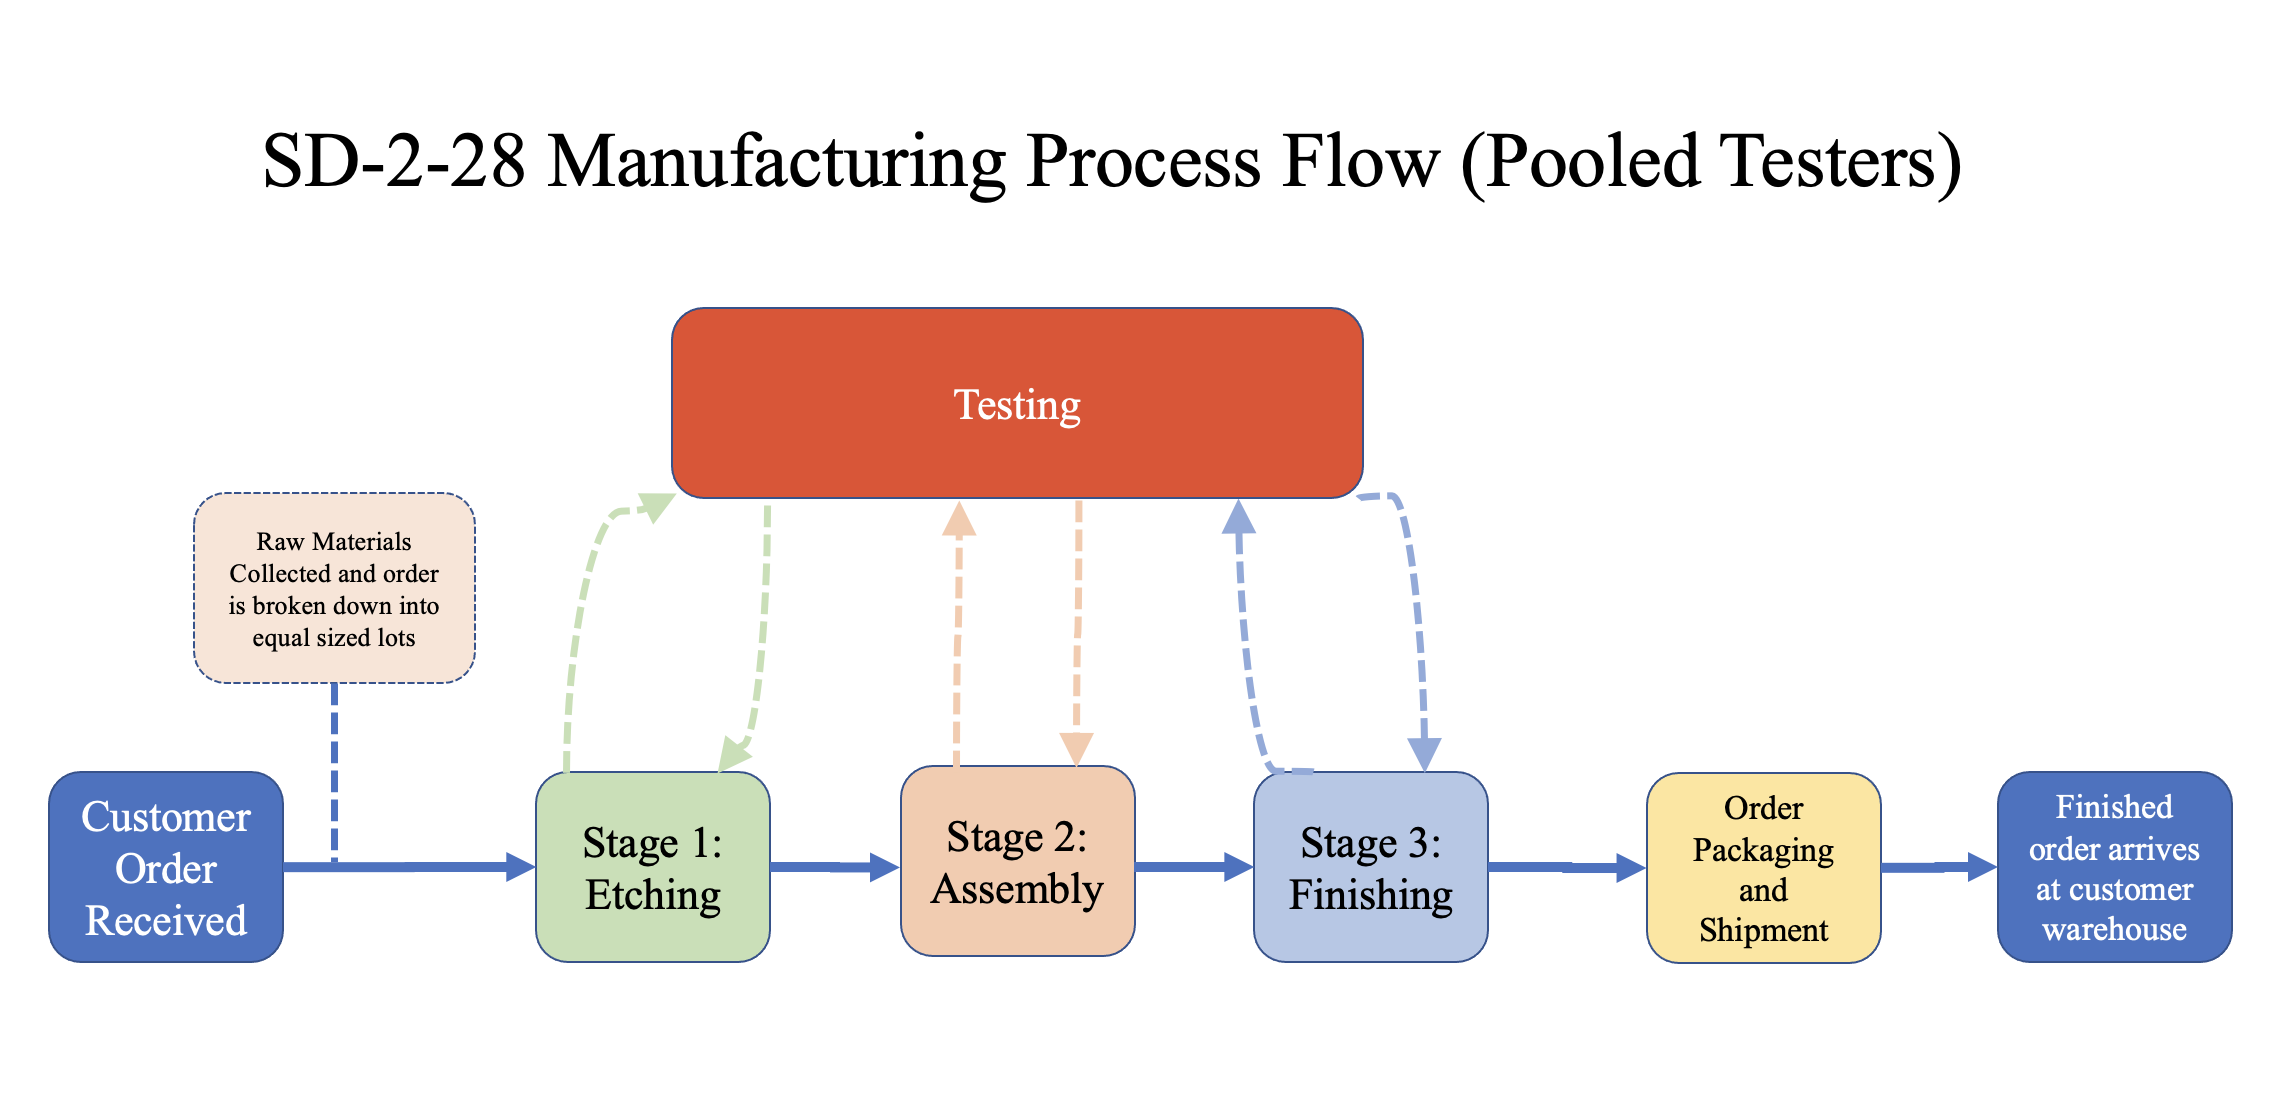

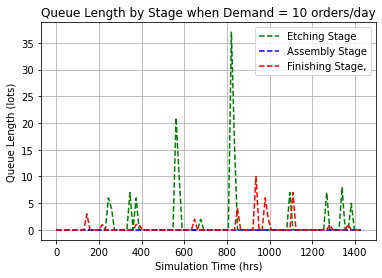

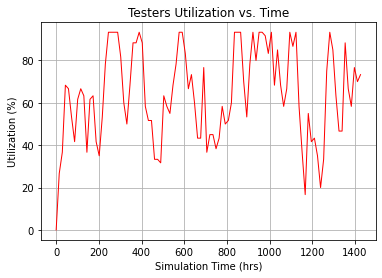

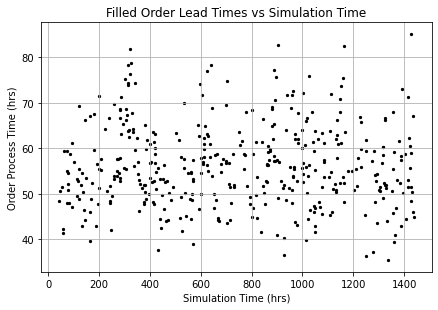

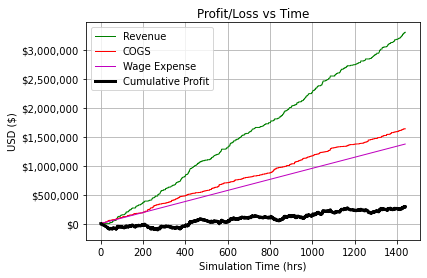


----------------------------------------------------------------
                  After 60.0 simulated days
----------------------------------------------------------------
       Total Possible Orders:        431
       Total On-Time Orders:         297
       Total Late Orders:            126
       On-Time Fill Rate:            68.91%
       Failed Test Count:            180
       Average Order Fill Time:      56.22 hours
       95th percentile Fill Time:    72.56 hours 
----------------------------------------------------------------
             Revenue:               $3,297,523.56
             COGS:                  -$1,635,000.00
             Wage Expenses:         -$1,370,880.00
                                    ---------------
             Gross Profit:          $291,643.56
             Gross Margin:          8.84%
----------------------------------------------------------------


In [21]:
%run Olympic_PooledTesters.py

##### Results
The above results demonstrate that while not large, we still were able to increase our gross margin by almost 3.6%, resulting in an almost **\$130k** increase in gross income. After a year, this one cost-free change would add over **$750k** in gross income for the plant. 

While this process change does positively affect bottom line, this does not do enough to address long lead times. We are still late on 31% of total orders. What else can we do?

## Solution 2: Lot Sizing 

As discussed earlier, orders flow through our plant via lots. Currently every order has 5 lots of 10 units that flow independently of one another. This number of units per lot is constrained by the machines themselves, we cannot fit any more in the machine at a time. 

Fortunately, we can actually get significant improvements by instead *reducing* our lot size. For a linear system like Olympic's, there exists a natural flow rate that the system can handle. This natural flow rate is dependent on many factors, and when the incoming demand matches this natural rate, the system operates in harmony and is considered stable. 

When a system is flooded with demand that is larger than that natural flow rate, you get unpredictable effects on the system (ie. whiplash effect, longer lead times, exponentially increasing queue times). 

A similar analog is when a ship is travelling above a certain speed, its propellers experience cavitation, which causes extreme vibration and drag, resulting in a dramatic slowing of the ship until it returns to that certain speed, unless you add significantly more power to the engine. 

Currently Olympic's system is experiencing this 'cavitation' because the lot size is not tuned to match what the system can handle. If we adjust this lot size, observe its effects on lead times, and repeat, we can then find an optimal lot size. In working with this model, I've found that the **optimal lot size is 5**, meaning 10 lots per order. The following is the same initial model but with a lot size of 5:


----------------------------------------------------------------
                  After 60.0 simulated days
----------------------------------------------------------------
       Total Possible Orders:        419
       Total On-Time Orders:         415
       Total Late Orders:            0
       On-Time Fill Rate:            99.05%
       Failed Test Count:            339
       Average Order Fill Time:      28.14 hours
       95th percentile Fill Time:    38.01 hours 
----------------------------------------------------------------
             Revenue:               $3,735,000.00
             COGS:                  -$1,582,500.00
             Wage Expenses:         -$1,468,800.00
                                    ---------------
             Gross Profit:          $683,700.00
             Gross Margin:          18.31%
----------------------------------------------------------------


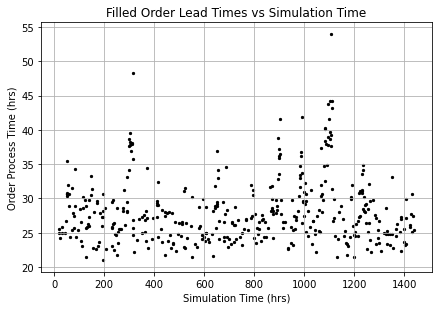

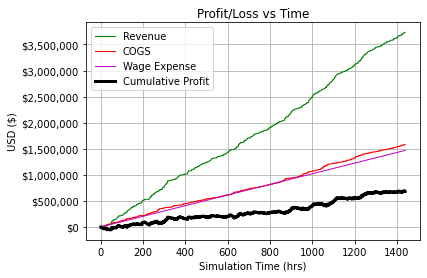

In [18]:
%run Olympic_LotSize.py

#### Results

Remarkably, the average order fill time dropped to 28 hours. Even the 95th percentile of orders were being filled in under 40 hours, resulting in a fill rate of 99%. Our bottom line also increased dramatically, expanding gross margin by over 13%!

This is an exceptionally significant improvement by simply cutting the units per lot in half. The system is now operating at its natural flow rate. But we can actually do better. 

## Solution 3: Combined Strategy 

As a result of the change in lot size, we actually are completing orders in almost *half the time that we were before*. This results in some extra capacity, but some residual variability in the system. If we combine the pooling strategy with lot sizing, we can both reduce variability and lead times simultaneously. 

Additionally, we can even figure out how much capacity we really don't need. The below script is the results of the combined strategy along with reducing testing capacity by 10 testers (optimal reduction).

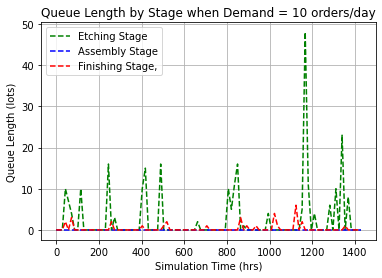

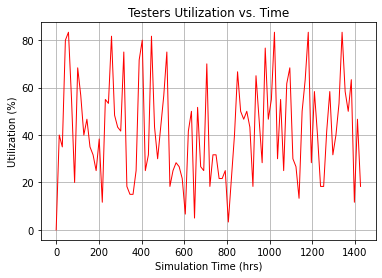

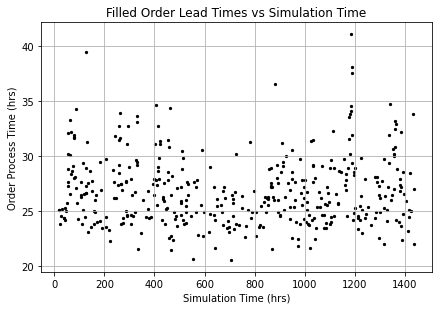

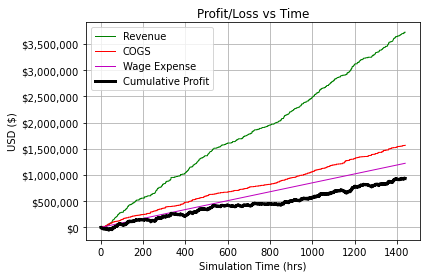


----------------------------------------------------------------
                  After 60.0 simulated days
----------------------------------------------------------------
       Total Possible Orders:        414
       Total On-Time Orders:         414
       Total Late Orders:            0
       On-Time Fill Rate:            100.00%
       Failed Test Count:            326
       Average Order Fill Time:      26.83 hours
       95th percentile Fill Time:    32.74 hours 
----------------------------------------------------------------
             Revenue:               $3,726,000.00
             COGS:                  -$1,567,500.00
             Wage Expenses:         -$1,224,000.00
                                    ---------------
             Gross Profit:          $934,500.00
             Gross Margin:          25.08%
----------------------------------------------------------------


In [20]:
%run Olympic_Combined.py

## Results

The above plots and summary demonstrate that we could squeeze even more performance out of our system. Average order fill time went down by almost 1.4 hours and the 95th percentile dropped by 5.3 hours. Gross margin shot up by most 7 more percent. Additionally, the reduced variability even resulted in a 100% on-time fill rate. This combined strategy is a significant improvement on all previous models. 

# Conclusion

As this project demonstrates, we can achieve outsized positive effects on a system by modeling its dynamics and manipulating its structure to squeeze out performance. We were able to demonstrate that a manufacturing plant could cut lead times in half and expand gross margins by 20% without spending a single cent in capital investment. Annually, this results in an additional $4.6 million in gross income.

Both solutions 1 and 2 presented unconventional approaches that may not be intuitive to a plant manager. Common sense would argue that one should increase lot size instead of reduce it to increase lead times, but in fact the opposite is true. Additionally, by combining the two solutions, we were able to tackle the challenges of unpredictable variability and profitability simultenously. This highlights the value of data-driven decision making and thoughtful systems design. 


Thank you for sticking around until the end of this project long enough to read the conclusion. I hope this project brings some value to you. If you have any questions or some constructive feedback, please feel free to send me an email at cfield06@mit.edu